In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Fixer la graine pour la reproductibilité
np.random.seed(42)


# 1. Générer un échantillon original (simulation)
# En réalité, ce serait vos vraies données
alpha = 0.95
n = int(100/(alpha*(1-alpha)))  # taille de l'échantillon
vraie_variance = 0.95  # variance théorique (inconnue en pratique)
echantillon_original = np.random.normal(0, np.sqrt(vraie_variance), n)
empirique_variance = np.var(echantillon_original, ddof=1)

# Pour 90% de confiance: α = 0.10, donc quantiles à 5% et 95%
alpha_oc = 0.10

print(f"Échantillon original (n={n}):")
print(f"Données: {np.round(echantillon_original, 2)}")
print(f"Variance empirique: {np.round(empirique_variance, 2)}")
print(f"Vraie variance (théorique): {vraie_variance}")
print("-" * 50)

Échantillon original (n=2105):
Données: [ 0.48 -0.13  0.63 ... -0.85  1.1  -1.16]
Variance empirique: 0.93
Vraie variance (théorique): 0.95
--------------------------------------------------


In [52]:
# 2. Bootstrap avec remise
k = 10000  # nombre de ré-échantillonnages
variances_bootstrap = []

for i in range(k):
    # Piocher avec remise dans l'échantillon original
    echantillon_bootstrap = np.random.choice(echantillon_original, size=n, replace=True)
    
    # Calculer la variance de cet échantillon bootstrap
    var_bootstrap = np.var(echantillon_bootstrap, ddof=1)
    variances_bootstrap.append(var_bootstrap)

variances_bootstrap = np.array(variances_bootstrap)

In [53]:
# 3. Analyse de la distribution des variances bootstrap
mediane_variance = np.median(variances_bootstrap)
moyenne_variance = np.mean(variances_bootstrap)

print(f"Résultats Bootstrap (k={k} ré-échantillonnages):")
print(f"Médiane des variances bootstrap: {mediane_variance:.3f}")
print(f"Moyenne des variances bootstrap: {moyenne_variance:.3f}")
print("-" * 50)

Résultats Bootstrap (k=10000 ré-échantillonnages):
Médiane des variances bootstrap: 0.926
Moyenne des variances bootstrap: 0.926
--------------------------------------------------


In [54]:
# 4. Intervalle de confiance à 90%
borne_inf = np.percentile(variances_bootstrap, 100 * alpha_oc/2)  # 5%
borne_sup = np.percentile(variances_bootstrap, 100 * (1 - alpha_oc/2))  # 95%

print(f"Intervalle de Confiance à 90% pour la variance:")
print(f"IC_90% = [{borne_inf:.3f}, {borne_sup:.3f}]")
print(f"Estimateur ponctuel (médiane): {mediane_variance:.3f}")
print()
print(f"Vérification: La vraie variance {vraie_variance} est-elle dans l'IC?")
print(f"Réponse: {borne_inf <= vraie_variance <= borne_sup}")
print("-" * 50)

Intervalle de Confiance à 90% pour la variance:
IC_90% = [0.878, 0.975]
Estimateur ponctuel (médiane): 0.926

Vérification: La vraie variance 0.95 est-elle dans l'IC?
Réponse: True
--------------------------------------------------


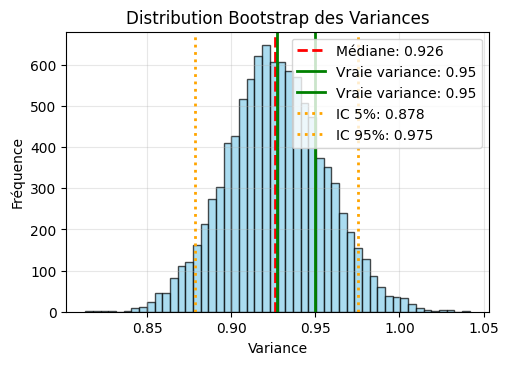

In [55]:
# 5. Visualisation
plt.figure(figsize=(12, 8))

# Histogramme des variances bootstrap
plt.subplot(2, 2, 1)
plt.hist(variances_bootstrap, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mediane_variance, color='red', linestyle='--', linewidth=2, label=f'Médiane: {mediane_variance:.3f}')
plt.axvline(vraie_variance, color='green', linestyle='-', linewidth=2, label=f'Vraie variance: {vraie_variance}')
plt.axvline(empirique_variance, color='green', linestyle='-', linewidth=2, label=f'Vraie variance: {vraie_variance}')
plt.axvline(borne_inf, color='orange', linestyle=':', linewidth=2, label=f'IC 5%: {borne_inf:.3f}')
plt.axvline(borne_sup, color='orange', linestyle=':', linewidth=2, label=f'IC 95%: {borne_sup:.3f}')
plt.xlabel('Variance')
plt.ylabel('Fréquence')
plt.title('Distribution Bootstrap des Variances')
plt.legend()
plt.grid(True, alpha=0.3)

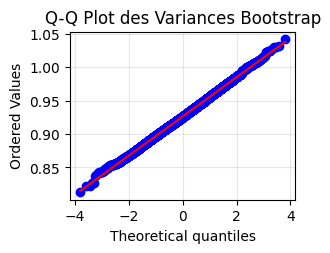

In [56]:
# Q-Q plot pour vérifier la normalité
plt.subplot(2, 2, 2)
stats.probplot(variances_bootstrap, dist="norm", plot=plt)
plt.title('Q-Q Plot des Variances Bootstrap')
plt.grid(True, alpha=0.3)

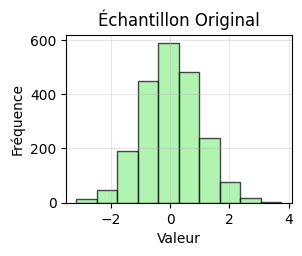

In [57]:
# Données originales
plt.subplot(2, 2, 3)
plt.hist(echantillon_original, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Échantillon Original')
plt.grid(True, alpha=0.3)

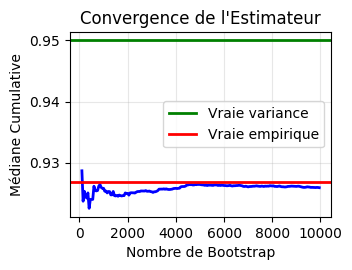

In [58]:
# Convergence de la médiane
plt.subplot(2, 2, 4)
medianes_cumulatives = [np.median(variances_bootstrap[:i+1]) for i in range(100, k, 50)]
plt.plot(range(100, k, 50), medianes_cumulatives, 'b-', linewidth=2)
plt.axhline(vraie_variance, color='green', linestyle='-', linewidth=2, label='Vraie variance')
plt.axhline(empirique_variance, color='red', linestyle='-', linewidth=2, label='Vraie empirique')
plt.xlabel('Nombre de Bootstrap')
plt.ylabel('Médiane Cumulative')
plt.title('Convergence de l\'Estimateur')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# 6. Comparaison avec la méthode classique (Chi-carré)
print("Comparaison avec la méthode classique (Chi-carré):")
chi2_alpha_2 = stats.chi2.ppf(1 - alpha/2, df=n-1)
chi2_1_alpha_2 = stats.chi2.ppf(alpha/2, df=n-1)

s2_empirique = np.var(echantillon_original, ddof=1)
ic_classique_inf = (n-1) * s2_empirique / chi2_alpha_2
ic_classique_sup = (n-1) * s2_empirique / chi2_1_alpha_2

print(f"IC classique (Chi-carré): [{ic_classique_inf:.3f}, {ic_classique_sup:.3f}]")
print(f"IC Bootstrap:             [{borne_inf:.3f}, {borne_sup:.3f}]")
print(f"Largeur IC classique:     {ic_classique_sup - ic_classique_inf:.3f}")
print(f"Largeur IC Bootstrap:     {borne_sup - borne_inf:.3f}")

Comparaison avec la méthode classique (Chi-carré):
IC classique (Chi-carré): [0.882, 0.976]
IC Bootstrap:             [0.880, 0.975]
Largeur IC classique:     0.094
Largeur IC Bootstrap:     0.095
